In [68]:
# load resource usage data

import pandas as pd

FILENAME = 'resource_usage.csv'

df1 = pd.read_csv(
    FILENAME,
    sep=';',
    header=0,
)
df1.rename(columns={'Unnamed: 0': 'metrics'}, inplace=True)

rename_cols = {col: '_'.join(col.split('_')[1:]).lower() for col in df1.columns if not col == 'metrics'}
df1.rename(columns=rename_cols, inplace=True)
# resource_usages = dict(zip(df.columns, df.iloc[0]))
# resource_usages.pop('Unnamed: 0')
df1["metrics"] = df1.metrics[0].upper()
df1.index = df1.metrics
df1.drop(columns=['metrics'], inplace=True)
df1 = df1.astype(int)
df1

,mvnn,nn,cp_nn,la_nn,qhgbr,hgbr,cp_hgbr,qr,linreg,cp_linreg,gp
metrics,,,,,,,,,,,
RESOURCE_USAGE,5,7,6,1,5,2,2,5,1,1,3


In [69]:
# load metrics

FILENAME = 'metrics_comparison_test.csv'

def get_metrics_df(filename):
    df = pd.read_csv(
        filename,
        sep=';',
        header=1,
        # index_col=0,
    )
    df.rename(columns={'Unnamed: 0': 'metrics'}, inplace=True)
    df.drop(columns=['optimal', 'miserable'], inplace=True)
    # drop_cols = ...
    # df.drop(columns=)
    # df.drop(index=df[df.metrics == 'SMAPE'].index, inplace=True)
    return df


df2 = get_metrics_df(FILENAME)
df2.index = df2.metrics
df2.drop(columns=['metrics'], inplace=True)
df2.rename(index={'SMAPE (x100)': 'SMAPE_SCALED', 'ABS MISCOV (%)': 'ABS_MISCOV', 'ABS MISCALIBR (%)': 'ABS_MISCALIBR'}, inplace=True)
df2.replace(r'(\d+),(\d+)', r'\1.\2', regex=True, inplace=True)  # convert to floats
df2 = df2.astype(float)
df2

,hgbr,linreg,nn,gp,mvnn,qhgbr,qr,cp_hgbr,cp_linreg,cp_nn,la_nn
metrics,,,,,,,,,,,
MAE,137.00,212.30,152.50,135.70,153.00,146.00,144.50,137.00,212.30,152.50,152.50
RMSE,182.20,283.40,197.20,179.50,197.50,193.40,188.00,182.20,283.40,197.20,197.20
SMAPE_SCALED,1.07,1.68,1.19,1.04,1.20,1.13,1.12,1.07,1.68,1.19,1.19
CRPS,NaN,NaN,NaN,96.30,111.20,95.10,103.50,99.20,152.80,108.40,108.20
PINBALL,NaN,NaN,NaN,49.00,56.40,52.30,52.70,50.40,78.00,55.20,55.10
NLL,NaN,NaN,NaN,6.60,6.97,6.66,6.69,6.68,7.07,6.71,6.70
SSR,NaN,NaN,NaN,0.88,0.68,0.82,0.93,0.80,1.05,0.90,0.97
ABS_MISCOV,NaN,NaN,NaN,3.30,12.40,6.80,5.30,5.00,1.80,2.90,1.20
ABS_MISCALIBR,NaN,NaN,NaN,6.30,13.60,3.90,5.10,3.20,3.80,5.70,5.50


In [71]:
# concat
df = pd.concat([df2, df1])
df

,hgbr,linreg,nn,gp,mvnn,qhgbr,qr,cp_hgbr,cp_linreg,cp_nn,la_nn
metrics,,,,,,,,,,,
MAE,137.00,212.30,152.50,135.70,153.00,146.00,144.50,137.00,212.30,152.50,152.50
RMSE,182.20,283.40,197.20,179.50,197.50,193.40,188.00,182.20,283.40,197.20,197.20
SMAPE_SCALED,1.07,1.68,1.19,1.04,1.20,1.13,1.12,1.07,1.68,1.19,1.19
CRPS,NaN,NaN,NaN,96.30,111.20,95.10,103.50,99.20,152.80,108.40,108.20
PINBALL,NaN,NaN,NaN,49.00,56.40,52.30,52.70,50.40,78.00,55.20,55.10
NLL,NaN,NaN,NaN,6.60,6.97,6.66,6.69,6.68,7.07,6.71,6.70
SSR,NaN,NaN,NaN,0.88,0.68,0.82,0.93,0.80,1.05,0.90,0.97
ABS_MISCOV,NaN,NaN,NaN,3.30,12.40,6.80,5.30,5.00,1.80,2.90,1.20
ABS_MISCALIBR,NaN,NaN,NaN,6.30,13.60,3.90,5.10,3.20,3.80,5.70,5.50


In [204]:
# setup

import matplotlib.pyplot as plt
import numpy as np
from functools import partial, reduce


MODEL_BY_TYPE = {
    'native': [
        'qr',
        'qhgbr',
        'mvnn',
        'gp',
    ],
    'base': [
        'linreg',
        'hgbr',
        'nn',
    ],
    'posthoc': [
        'cp_linreg',
        'cp_hgbr',
        'cp_nn',
        'la_nn',
    ]
}

USAGE_TO_STR_DICT = {
    1: ['minimal (MIN)', 'MIN'],
    2: ['very low (VL)', 'VL'],
    3: ['low (L)', 'L'],
    4: ['medium (M)', 'M'],
    5: ['high (H)', 'H'],
    6: ['very high (VH)', 'VH'],
    7: ['maximal (MAX)', 'MAX'],
}

BASELINES = ['linreg', 'cp_linreg', 'qr']

plotting without baselines
plotting with baselines
plotting without baselines
plotting with baselines
showing


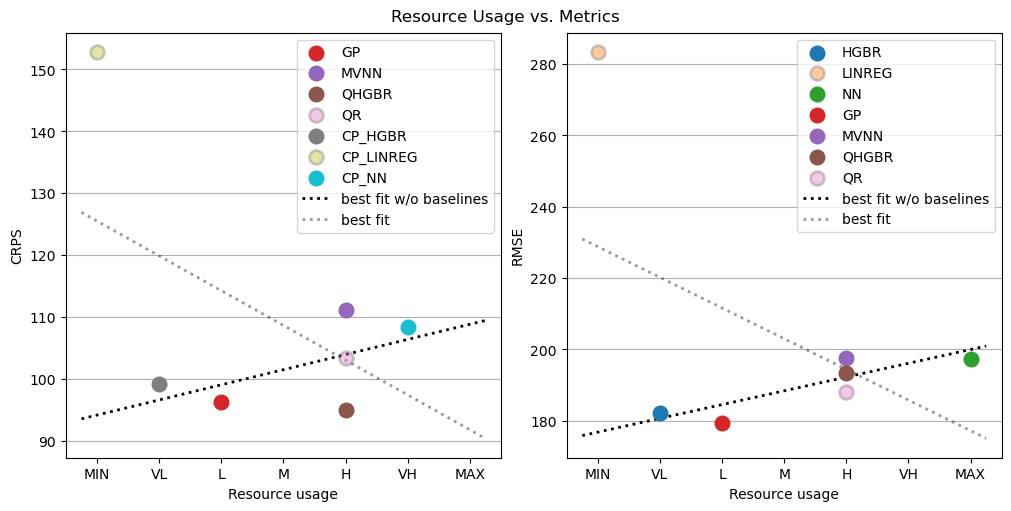

In [205]:
SCATTER_SIZE = 10 **2
SCATTER_ALPHA = 1
SCATTER_ALPHA_BASELINE = 0.4
DPI = 100
SAVE_FIG = False
FILEPATH = 'comparison_storage/plots/resources_vs_metrics.png'
X_SHIFT = 0.5
INCLUDE_PLOT_NO_BASELINES = True


def plot_linreg(cols_filtered, resource_usages_filtered, metric_values_filtered, ax, plot_baselines=True, x_pred=None):
    if not plot_baselines:
        cols_filtered, resource_usages_filtered, metric_values_filtered = cols_filtered.copy(), resource_usages_filtered.copy(), metric_values_filtered.copy()
        for baseline in BASELINES:
            if baseline not in cols_filtered:
                continue
            index = cols_filtered.index(baseline)
            for arr in [cols_filtered, resource_usages_filtered, metric_values_filtered]:
                arr.pop(index)
    metric_values_pred = get_linreg(resource_usages_filtered, metric_values_filtered, x_pred=x_pred)
    label = 'best fit'
    if not plot_baselines:
        label = f'{label} w/o baselines'
        alpha = SCATTER_ALPHA
    else:
        alpha = SCATTER_ALPHA_BASELINE
    ax.plot(x_pred, metric_values_pred, color='black', linestyle='dotted', zorder=2, label=label, alpha=alpha, linewidth=2)  # color=color, 

def get_linreg(resource_usages_filtered, metric_values_filtered, x_pred=None):
    # based on: https://stackoverflow.com/a/6148315/
    if x_pred is None:
        x_pred = resource_usages_filtered
    coef = np.polyfit(resource_usages_filtered, metric_values_filtered, 1)
    poly1d_fn = np.poly1d(coef) 
    metric_values_pred = poly1d_fn(x_pred)
    return metric_values_pred

def pop_all(list_, indices):
    items = [list_.pop(index) for index in indices]
    return items


metrics = [
    'CRPS',
    'RMSE',
]


COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

# todo: take care of when just 1 metric?
fig, axs = plt.subplots(1, len(metrics), figsize=(10, 5), layout='constrained', dpi=DPI)
fig.suptitle('Resource Usage vs. Metrics')

for ax, metric in zip(axs, metrics):
    resource_usages = df.loc['RESOURCE_USAGE']
    metric_values = df.loc[metric]
    cols_filtered, resource_usages_filtered, metric_values_filtered, colors_filtered = [], [], [], []
    columns = reduce(lambda a, b: a+b, MODEL_BY_TYPE.values())
    for col, resource_usage, metric_value, color in zip(df.columns, resource_usages, metric_values, COLORS):
        if metric == 'CRPS' and np.isnan(metric_value):
            continue
        elif metric == 'RMSE' and col in MODEL_BY_TYPE['posthoc']:
            continue
        cols_filtered.append(col)
        resource_usages_filtered.append(resource_usage)
        metric_values_filtered.append(metric_value)
        
        if col in BASELINES and INCLUDE_PLOT_NO_BASELINES:
            alpha = SCATTER_ALPHA_BASELINE
            edgecolor = 'grey'
            linewidths = 2
        else:
            alpha = SCATTER_ALPHA
            edgecolor = 'face'
            linewidths = 1.5
        ax.scatter(resource_usage, metric_value, color=color, label=col.upper(), s=SCATTER_SIZE, alpha=alpha, edgecolors=edgecolor, linewidths=linewidths, zorder=3)

    x_plot_min, x_plot_max = 1-X_SHIFT, 7+X_SHIFT
    x_pred = [1 - X_SHIFT/2, 7 + X_SHIFT/2]
    plot_linreg_partial = partial(plot_linreg, cols_filtered, resource_usages_filtered, metric_values_filtered, ax, x_pred=x_pred)
    if INCLUDE_PLOT_NO_BASELINES:
        plot_linreg_partial(plot_baselines=False)
    plot_linreg_partial(plot_baselines=True)
        
    ax.set_xlim(x_plot_min, x_plot_max)
    ax.set_xticks(range(1, 7+1), map(lambda pair: pair[1], USAGE_TO_STR_DICT.values()))
    ax.grid(axis='y', zorder=-1)
    ax.set_xlabel('Resource usage')
    ax.set_ylabel(metric)
    ax.legend()
    
    # # from: https://www.geeksforgeeks.org/how-to-make-a-square-plot-with-equal-axes-in-matplotlib/
    # ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

if SAVE_FIG:
    print('saving')
    plt.savefig(FIGURE_PATH)
print('showing')
plt.show()